# PiML Model Interpretability

- Data Pipeline

- Binning Logistic and XGB1

- XGBoost Benign Overfitting

- Post-hoc Explainability

- Inherently Interpretable Benchmark Models
  - FANOVA Models (XGB2 and GAMI-Net)
  - Inherent Interpretability
  - Monotonic Constraints



In [ ]:
!pip install piml

In [2]:
from piml import Experiment
exp = Experiment()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 1) Data Pipeline

In [3]:
# Choose SimuCredit
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [4]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [5]:
# remove "Gender" and "Race" (Categorical)
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [6]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 2) Machine Learning Models

In [7]:
# Build XGBoost model with max_depth 3
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=3, n_estimators=1000,
                      learning_rate=0.01, random_state=0)
exp.model_train(model, name="XGB-default")

exp.model_diagnose(model="XGB-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7033,0.7722,0.7265,0.5676,0.1931
Test,0.6890,0.7564,0.7153,0.5845,0.1997
Gap,-0.0143,-0.0158,-0.0112,0.0169,0.0066


In [8]:
# Build ReLU Deep Neural Networks with [20]*3 hidden nodes
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[20]*3,
                      activation="relu", random_state=0)
exp.model_train(model, name='MLP-default')

exp.model_diagnose(model="MLP-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.6941,0.7576,0.7218,0.5803,0.1983
Test,0.6935,0.7554,0.7215,0.5867,0.2000
Gap,-0.0006,-0.0022,-0.0003,0.0064,0.0017


## 3) Hyperparameter Tuning

In [9]:
# Hyperparameter Tuning with Grid Search
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
result = exp.model_tune(model="XGB-default",
                        method="grid",
                        parameters=parameters,
                        metric=['AUC', 'LogLoss'],
                        test_ratio=0.4,
                        random_state=0)
result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Rank(by AUC),AUC,LogLoss,time
params,,,,
{'max_depth': 3},1,0.752090,0.588135,2.079706
{'max_depth': 2},2,0.751441,0.588816,0.631505
{'max_depth': 4},3,0.749131,0.591288,1.462235
{'max_depth': 5},4,0.747925,0.593690,1.325948
{'max_depth': 6},5,0.743697,0.599636,1.729064
{'max_depth': 7},6,0.741206,0.603746,2.262933
{'max_depth': 8},7,0.735205,0.612239,2.982731
{'max_depth': 1},8,0.732021,0.606960,0.556661


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

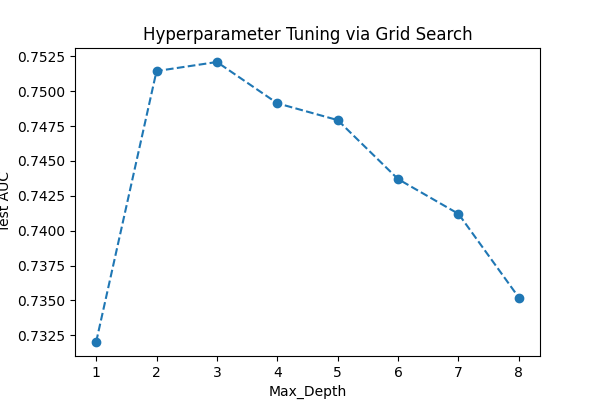

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 1+result.data.shape[0]), result.cv_results_["mean_test_AUC"], '--o')
plt.xlabel("Max_Depth")
plt.ylabel("Test AUC")
plt.title("Hyperparameter Tuning via Grid Search")
plt.show()

In [11]:
import scipy
parameter_space = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                   'n_estimators': scipy.stats.randint(100, 2000),
                   'learning_rate': scipy.stats.loguniform(0.001, 1.0)}
result = exp.model_tune(model="XGB-default",
                        method="randomized",
                        parameters=parameter_space,
                        metric=["AUC", "LogLoss"],
                        n_runs=100,
                        test_ratio=0.4,
                        random_state=0)
# result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

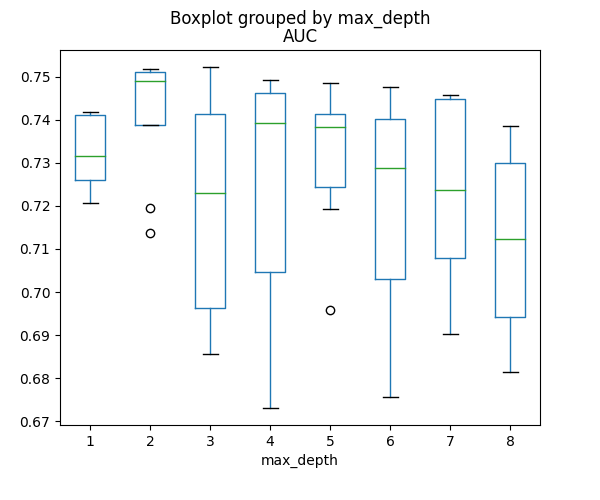

In [12]:
import pandas as pd
df = pd.concat([pd.DataFrame(result.cv_results_['params']),
                pd.DataFrame(result.cv_results_["mean_test_AUC"], columns=["AUC"]),
                pd.DataFrame(result.cv_results_["mean_test_LogLoss"], columns=["LogLoss"])], axis=1)
df.boxplot(column=['AUC'], by='max_depth', grid=False, figsize=(6, 5))
plt.show()

In [13]:
params = result.get_params_ranks(rank=1)
params

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'learning_rate': 0.009183150969807761, 'max_depth': 3, 'n_estimators': 1107}

In [14]:
exp.model_train(XGBClassifier(**params), name="XGB-HPO")

exp.model_diagnose(model="XGB-HPO", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7023,0.7724,0.7255,0.5674,0.1930
Test,0.6903,0.7569,0.7159,0.5841,0.1995
Gap,-0.0121,-0.0155,-0.0096,0.0167,0.0065


## 4) Post-hoc Explainability

In [15]:
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 5) Inherently Interpretable Benchmark Models


In [16]:
# Choose Models: XGB2, GAMI-Net (default config)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

### Inherent Interpretability

In [17]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### Monotonic Constraints

In [18]:
# Choose Model: XGB2-Mono (n_estimators = 1000, eta = 0.01), GAMI-Net-Mono
# Feature_increasing =  "Balance",
# Feature_decreasing =  "Utilization",
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [19]:
# Choose XGB2-Mono, GAMI-Net
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [20]:
# Choose XGB-default, XGB2, GAMI-Net-Mono: Overfit (Delinquency, AUC), noise step = 0.05
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…